# Lexical Hybrid Feature Selection (RF)

In [2]:
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import filter_feature_selection
import scipy.stats as stats

The first stage of this feature selection technique utilizes the filter-based methods to reduce the featureset.

The respective F-score of the features are then calculated using ANOVA. The higher the F-score, the better a feature is.

In [3]:
anova_features, anova_f_scores = filter_feature_selection.anova_feature_selection('final_unbalanced_with_lexical.csv')

c:\Users\Eri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [15 51 55] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Eri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [4]:
anova_f_scores = [i for i in anova_f_scores if str(i) != 'nan']
anova_f_scores = np.array(anova_f_scores)

Using the computed F-scores, the Z-scores are obtained so that the features with F-scores belonging in the upper 50 percentile are selected.

In [5]:
anova_z_scores = stats.zscore(anova_f_scores)

In [6]:
percentile = []
for z_score in anova_z_scores:
    percentile.append(stats.norm.cdf(z_score))

In [7]:
feature_percentile_dict = {}
print('Feature Percentile: ')
for i in range(len(percentile)):
    print(anova_features[i], ': ', percentile[i])
    if percentile[i] > 0.50:
        feature_percentile_dict[anova_features[i]] = percentile[i]

Feature Percentile: 
url_host_length :  0.9999999154054002
url_is_https :  0.9851449114414272
url_ip_in_domain :  0.984454144298416
has_php_in_string :  0.9801919264023486
url_number_of_parameters :  0.9723791520118684
has_exe_in_string :  0.9714855635190668
url_has_port :  0.969543544206523
url_num_equal :  0.9694476816886433
url_num_ampersand :  0.9566690361059697
url_is_digits_in_domain :  0.8696903322040741
url_path_length :  0.7590513353039839
url_num_question_mark :  0.7087181178585258
url_query_length :  0.6018388999372104
url_string_entropy :  0.5361937075903936
url_num_periods :  0.5304886673539473
url_num_forward_slash :  0.45782323516996204
url_domain_len :  0.44680580887724913
url_number_of_subdirectories :  0.440767844819599
has_linkeq_in_string :  0.4270448461906734
url_num_of_hyphens :  0.42440112619347753
url_number_of_letters :  0.4215869349576995
url_domain_entropy :  0.4129542634720332
url_length :  0.40423422463569514
url_num_underscore :  0.36256077818091026
has_jp

Shown below are the features with F-scores that belong in the upper 50 percentile.

In [8]:
feature_percentile_dict

{'url_host_length': 0.9999999154054002,
 'url_is_https': 0.9851449114414272,
 'url_ip_in_domain': 0.984454144298416,
 'has_php_in_string': 0.9801919264023486,
 'url_number_of_parameters': 0.9723791520118684,
 'has_exe_in_string': 0.9714855635190668,
 'url_has_port': 0.969543544206523,
 'url_num_equal': 0.9694476816886433,
 'url_num_ampersand': 0.9566690361059697,
 'url_is_digits_in_domain': 0.8696903322040741,
 'url_path_length': 0.7590513353039839,
 'url_num_question_mark': 0.7087181178585258,
 'url_query_length': 0.6018388999372104,
 'url_string_entropy': 0.5361937075903936,
 'url_num_periods': 0.5304886673539473}

Chi2 is used to determine the significance of categorical features. The higher the Chi2 statistics, the better a feature is and the lower its P value, the more significant the observation. Based on the results, both categorical features are to be retained.

In [9]:
filter_feature_selection.chi2_feature_selection('final_unbalanced_with_lexical.csv')

Chi2 Statistics: 
[88439618.85652827  6900658.46790684]
Chi2 P Values: 
[0. 0.]
get_tld       8.843962e+07
url_scheme    6.900658e+06
get_tld       0.0
url_scheme    0.0
dtype: float64


Features with high correlation are to be weeded out. This is to eliminate redundancy in the featureset.

In [10]:
features_high_correlation = filter_feature_selection.correlation_feature_selection('final_unbalanced_with_lexical.csv')

features_high_correlation

[['url_num_close_parenthesis', 'url_num_open_parenthesis'],
 ['url_domain_len', 'url_domain_entropy'],
 ['url_num_forward_slash', 'url_number_of_subdirectories'],
 ['url_num_ampersand', 'url_number_of_parameters', 'url_num_equal'],
 ['url_number_of_letters', 'url_length']]

In [16]:
to_remove = []

for feature in feature_percentile_dict:
    for high_corr_group in features_high_correlation:
        if feature in high_corr_group:
            for ref_feature in high_corr_group:
                if (ref_feature != feature) and (ref_feature in feature_percentile_dict.keys()):
                    if feature_percentile_dict[feature] >= feature_percentile_dict[ref_feature]:
                        print('Removed: ', ref_feature)
                        to_remove.append(ref_feature)
                        high_corr_group.remove(ref_feature)
                        #feature_percentile_dict.pop(ref_feature, None)
                    else:
                        print('Removed: ', feature)
                        to_remove.append(feature)
                        high_corr_group.remove(feature)
                        #feature_percentile_dict.pop(feature, None)

print(to_remove)

{'url_host_length': 0.9999999154054002, 'url_is_https': 0.9851449114414272, 'url_ip_in_domain': 0.984454144298416, 'has_php_in_string': 0.9801919264023486, 'url_number_of_parameters': 0.9723791520118684, 'has_exe_in_string': 0.9714855635190668, 'url_has_port': 0.969543544206523, 'url_is_digits_in_domain': 0.8696903322040741, 'url_path_length': 0.7590513353039839, 'url_num_question_mark': 0.7087181178585258, 'url_query_length': 0.6018388999372104, 'url_string_entropy': 0.5361937075903936, 'url_num_periods': 0.5304886673539473}


In [ ]:
for feature in to_remove:
    feature_percentile_dict.pop(feature, None)

In [17]:
final_anova_features = [key for key in feature_percentile_dict.keys()]

final_anova_features

['url_host_length',
 'url_is_https',
 'url_ip_in_domain',
 'has_php_in_string',
 'url_number_of_parameters',
 'has_exe_in_string',
 'url_has_port',
 'url_is_digits_in_domain',
 'url_path_length',
 'url_num_question_mark',
 'url_query_length',
 'url_string_entropy',
 'url_num_periods']

After combining the results of ANOVA and Chi2 and removing the highly correlated features, the final featureset is seen below.

In [18]:
final_features = final_anova_features + ['get_tld'] + ['url_scheme'] # ADD CATEGORICAL IF GOOD CHI2 SCORE AND SIGNIFICANT BASED ON P VALUE | WILL AUTOMATE LATER

final_features

['url_host_length',
 'url_is_https',
 'url_ip_in_domain',
 'has_php_in_string',
 'url_number_of_parameters',
 'has_exe_in_string',
 'url_has_port',
 'url_is_digits_in_domain',
 'url_path_length',
 'url_num_question_mark',
 'url_query_length',
 'url_string_entropy',
 'url_num_periods',
 'get_tld',
 'url_scheme']

Once the featureset has been reduced through the filter-based method, the reduced featureset will be ran through a forward feature selection selection algorithm with the respective machine learning model (RF) for further reduction.

The URL dataset with generated lexical features are read from a csv file. These are then displayed for visualization purposes.

In [19]:
dataset = pd.read_csv('final_unbalanced_with_lexical.csv')

In [20]:
features = dataset.iloc[:, 1:]
url_type = dataset.iloc[:, 0]

features = features.drop(columns = [col for col in features if col not in final_features])

features

,url_ip_in_domain,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_string_entropy,url_is_https,url_path_length,url_host_length,get_tld,url_has_port,url_num_periods,url_num_question_mark,has_exe_in_string,has_php_in_string,url_scheme
0,0,0,0,0,3.375000,0,16,0,0,0,2,0,0,0,0
1,0,1,0,0,4.079143,0,35,0,0,0,2,0,0,0,0
2,0,0,0,0,3.708093,0,31,0,0,0,2,0,0,0,0
3,0,0,49,4,4.660343,0,10,21,283,0,3,1,0,1,27
4,0,0,194,3,4.980518,0,10,23,459,0,2,1,0,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684177,0,0,0,0,4.151859,0,28,16,320,0,3,0,1,0,27
684178,0,0,0,0,4.298701,0,29,17,320,0,2,0,0,0,27
684179,0,0,0,0,4.187850,0,30,12,396,0,2,0,0,0,27
684180,0,1,0,0,4.778025,0,69,10,320,0,1,0,0,0,27


A forward feature selection algorithm is then ran on the dataset using RF with a scoring that's dependent on accuracy and a cross validatoin of 5.

In [22]:
forward_feature_selection = SequentialFeatureSelector(RandomForestClassifier(n_jobs = 1), k_features = 15, forward = True,
                                                      floating = False, verbose = 10, scoring = 'accuracy', n_jobs = 1).fit(features, url_type)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed: 24.2min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed: 29.7min

[2024-03-27 04:23:36] Features: 1/15 -- score: 0.7784255250722839[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed: 25.0min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed: 32.5min

[2024-03-27 04:58:50] Features: 2/15 -- score: 0.8371254933130052[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 10.1min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed: 22.5min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed: 29.6min

[2024-03-27 05:29:37] Features: 3/15 -- score: 0.8625719607743724[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel

Once all iterations have finished, the results of each iteration are displayed.

In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.7793414486459399, 0.7760633077902825, 0.7786605418384924, 0.780717231299264, 0.7773450957874406]",0.778426,"(get_tld,)",0.002064,0.001606,0.000803
2,"(6, 8)","[0.836896832522498, 0.836218236485499, 0.8369786501017905, 0.8379286944719946, 0.8376050529832437]",0.837125,"(url_path_length, get_tld)",0.000765,0.000595,0.000298
3,"(6, 7, 8)","[0.862151045037897, 0.8615350886350823, 0.8623062066085504, 0.8646447773659759, 0.8622226862243566]",0.862572,"(url_path_length, url_host_length, get_tld)",0.001377,0.001072,0.000536
4,"(6, 7, 8, 10)","[0.8721942663854844, 0.8712129121165932, 0.8717440100224461, 0.8735292582345878, 0.8720572114631727]",0.872148,"(url_path_length, url_host_length, get_tld, url_num_periods)",0.000988,0.000769,0.000384
5,"(2, 6, 7, 8, 10)","[0.8823732069404715, 0.8814753721838264, 0.8815367750691653, 0.8842720676515112, 0.8826956203998538]",0.882471,"(url_query_length, url_path_length, url_host_length, get_tld, url_num_periods)",0.001307,0.001017,0.000508
6,"(2, 5, 6, 7, 8, 10)","[0.8865909423088969, 0.8854112291984215, 0.886057315863653, 0.8876755233074072, 0.8867359189852273]",0.886494,"(url_query_length, url_is_https, url_path_length, url_host_length, get_tld, url_num_periods)",0.000966,0.000752,0.000376
7,"(2, 5, 6, 7, 8, 10, 13)","[0.889284446578832, 0.8887833295053557, 0.8892415305110404, 0.8903690556976562, 0.8896904525760818]",0.889474,"(url_query_length, url_is_https, url_path_length, url_host_length, get_tld, url_num_periods, has_php_in_string)",0.000684,0.000532,0.000266
8,"(1, 2, 5, 6, 7, 8, 10, 13)","[0.8904223999331844, 0.8900570020671079, 0.8905047763219711, 0.8919350629012893, 0.8907866576186251]",0.890741,"(url_is_digits_in_domain, url_query_length, url_is_https, url_path_length, url_host_length, get_tld, url_num_periods, has_php_in_string)",0.000824,0.000641,0.00032
9,"(1, 2, 5, 6, 7, 8, 10, 12, 13)","[0.8913933142630447, 0.8910279163969682, 0.891632301508587, 0.8927493866471786, 0.8915070209322963]",0.891662,"(url_is_digits_in_domain, url_query_length, url_is_https, url_path_length, url_host_length, get_tld, url_num_periods, has_exe_in_string, has_php_in_string)",0.000745,0.00058,0.00029
10,"(1, 2, 3, 5, 6, 7, 8, 10, 12, 13)","[0.8916021130436598, 0.8915603532875368, 0.8921647439578222, 0.8930730281359294, 0.8921125437177011]",0.892103,"(url_is_digits_in_domain, url_query_length, url_number_of_parameters, url_is_https, url_path_length, url_host_length, get_tld, url_num_periods, has_exe_in_string, has_php_in_string)",0.000702,0.000546,0.000273


The program then looks for when the accuracy plateaus. For this implementation, a plateau is when the accuracy does not increase by more than 0.1%.

In [24]:
all_iterations = pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict()).T
all_iterations_series = pd.Series(all_iterations['avg_score'])
all_iterations_list = all_iterations_series.to_list()

prev = all_iterations_list[0]
for accuracy in all_iterations_list[1:]:
    if accuracy > prev*1.001:
        prev = accuracy
        pass
    else:
        print('Plateus at: ', all_iterations_list.index(prev))

Plateus at:  8
Plateus at:  8
Plateus at:  8
Plateus at:  8
Plateus at:  8
Plateus at:  8


The features from the longest occuring plateau are extracted and is considered as the final featureset.

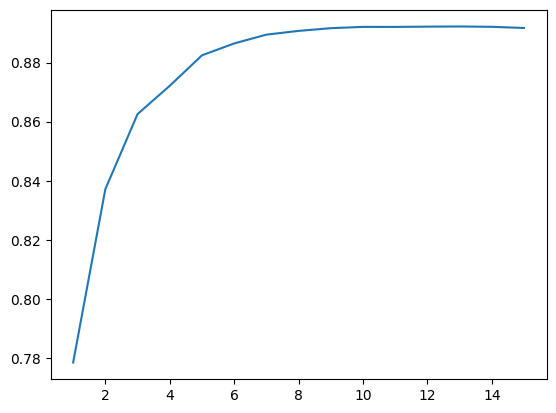

In [25]:
y_points = np.array(list(all_iterations['avg_score']))
x_points = np.array([i for i in range(1, len(y_points) + 1)])

plt.plot(x_points, y_points)